<a href="https://www.kaggle.com/code/tbillington/us-gun-violence-eda-in-python?scriptVersionId=162541160" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><img align="right" src="https://cdn.britannica.com/79/4479-050-6EF87027/flag-Stars-and-Stripes-May-1-1795.jpg" alt="US Flag" width="250">   United States gun violence data </h1>
<h2> Data from: Jan 2013 to Mar 2018 </h2>



Data obtained from the [Gun Violence Data](https://www.kaggle.com/datasets/jameslko/gun-violence-data) set on Kaggle.

***

## Importing packages

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import bokeh.plotting as bpl
import bokeh.models as bmo

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, GroupFilter, CDSView, GMapOptions
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256 
from bokeh.plotting import gmap
from bokeh.io import output_file, show

output_file("gmap.html")
output_notebook()

Loading BokehJS ...

In [2]:
# Importing gun violence data set
gun_violence = pd.read_csv('/kaggle/input/gun-violence-data/gun-violence-data_01-2013_03-2018.csv')


## Cleaning the data set

In [3]:
#Removing unnecessary columns
gun_violence_cleaned = gun_violence.drop(['state_senate_district', 
                                         'state_house_district', 
                                         'source_url','participant_name',
                                         'incident_url',
                                         'congressional_district',
                                         'location_description',
                                         'incident_url_fields_missing',
                                         'sources',
                                         'participant_status',
                                         'gun_stolen',
                                         'participant_type',
                                         'participant_age_group',
                                         'participant_age',
                                         'participant_gender',
                                         'participant_relationship'],
                                         axis=1).set_index('incident_id').copy()

In [4]:
# Replacing any values with 'unknown' in the cell with NaN
gun_violence_cleaned['gun_type'] = gun_violence_cleaned['gun_type'].mask(gun_violence_cleaned['gun_type'].str.contains('Unknown', na=False), np.nan)
gun_violence_cleaned['date'] = pd.to_datetime(gun_violence_cleaned['date']) #YYYY-MM-DD

gun_df = gun_violence_cleaned[(gun_violence_cleaned['n_injured'] != 0) | (gun_violence_cleaned['n_killed'] != 0)].copy() #Removing all rows where both fields are 0

***

# Analysis Objectives

> - Where are incidents where people are either <u>**killed**</u> or <u>**injured**</u> occuring?
> - Find the <u>**most dangerous state**</u> for gun crime
> - Find the <u>**city or county**</u> with <u>**most gun crime**</u> in Florida
> - Find the <u>**city or county**</u> with <u>**most gun crime**</u> in California

***

# Where are the shootings happening?

In [5]:
gun_df_killed = gun_df.copy()    # Create a copy of the dataframe

In [6]:
gun_df_killed = gun_df_killed[gun_df_killed['n_killed'] > 0]

In [7]:
gun_map = px.scatter_mapbox(gun_df_killed, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="state", 
                        hover_data={'city_or_county':True, 'n_killed':True, 'n_injured':True, 'latitude':False, 'longitude':False, },
                        color='n_killed',
                        color_continuous_scale = 'geyser',
                        zoom=2.8,
                        size='n_killed',
                        size_max=20,
                        height=600,
                        width=800)

gun_map.update_layout(mapbox_style="open-street-map")
gun_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
gun_map.show()


***

# Plotting incidents along Latitude

In [8]:
new_gun_df = gun_df.copy()
lats = new_gun_df[['longitude','latitude','n_killed','n_injured', 'city_or_county','state']].reset_index()
lats = lats.round(decimals=1).drop(columns=['incident_id'])
lats = lats.dropna()
lats['total'] = lats['n_killed'] + lats['n_injured']

In [9]:
lats_plotted = lats.groupby(['latitude'])['latitude'].sum().astype(int)

In [10]:
lats_plotted = pd.DataFrame(lats_plotted)
lats_plotted.rename(columns={'latitude':'count'}, inplace=True)
lats_plotted = lats_plotted.reset_index()

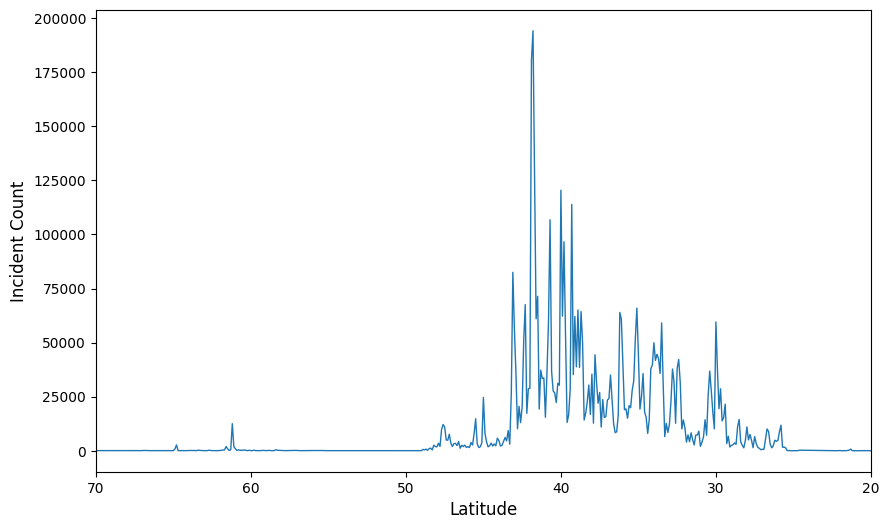

In [11]:
plt.figure(figsize=(10, 6))

# Create the barplot
sns.lineplot(data=lats_plotted, 
             x='latitude', 
             y='count',
             estimator=None,
             linewidth=1).invert_xaxis()

plt.xlabel('Latitude', fontsize=12)
plt.xticks(size=10)
plt.xlim(70,20)


plt.ylabel('Incident Count', fontsize=12)
plt.yticks(size=10)


# Show the plot
plt.show()


***

# Plotting incidents along Longitude

In [12]:
long_plotted = lats.groupby(['longitude'])['longitude'].sum().astype(int)

In [13]:
long_plotted = pd.DataFrame(long_plotted)
long_plotted.rename(columns={'longitude':'count'}, inplace=True)
long_plotted = long_plotted.reset_index()
long_plotted['count'] = long_plotted[['count']].abs()   # Converting negative values into positive values
long_plotted.sort_values(by='longitude', ascending=False, inplace=True)

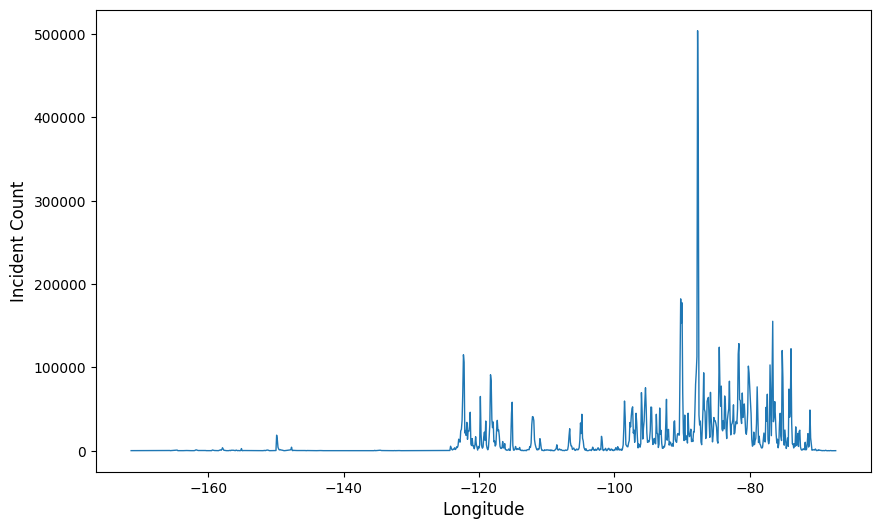

In [14]:
plt.figure(figsize=(10, 6))

# Create the barplot
sns.lineplot(data=long_plotted, 
             x='longitude', 
             y='count',
             estimator=None,
             linewidth=1)

plt.xlabel('Longitude', fontsize=12)
plt.xticks(size=10)


plt.ylabel('Incident Count', fontsize=12)
plt.yticks(size=10)


# Show the plot
plt.show()

***

# Frequency of people <u>*killed*</u> by guns in each state

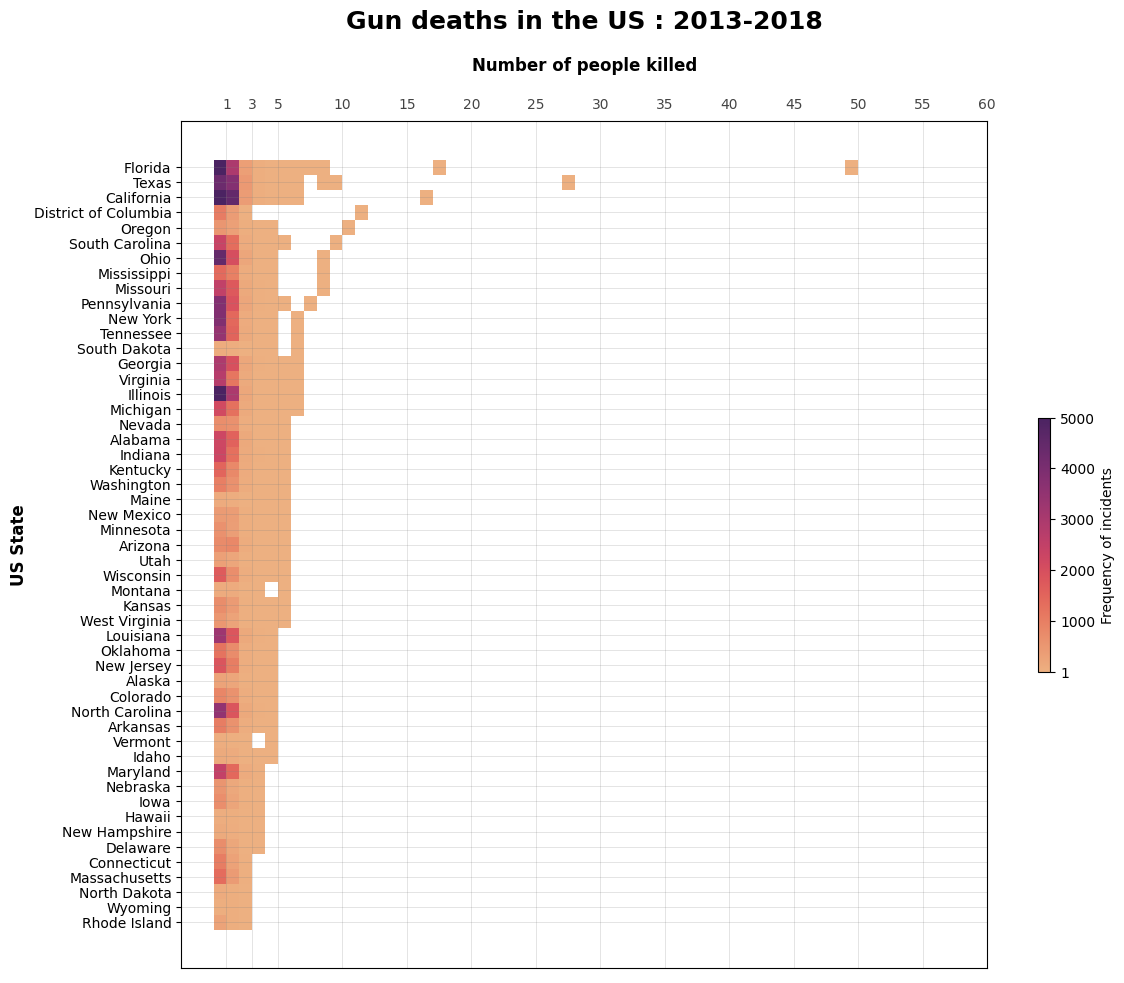

In [15]:
killed_sorted = gun_df.sort_values(by='n_killed', ascending=False)

plt.figure(figsize=(13,11))

sns.histplot(killed_sorted, 
             y="state", 
             x="n_killed", 
             alpha=1, 
             cmap='flare', 
             legend=True, 
             binwidth=1, 
             cbar=True,
             vmax=5000,
             cbar_kws={'shrink': 0.3,'label':'Frequency of incidents', 'ticks': [1,1000,2000,3000,4000,5000]})

plt.tick_params(axis='x', top=True, labeltop=True, labelbottom=False, color='white', width=0.5, labelcolor='#444444')
plt.title('Gun deaths in the US : 2013-2018', pad=20, size=18, fontweight='heavy')
plt.xlabel('Number of people killed', labelpad=-660, size=12, fontweight='heavy')
plt.ylabel('US State', size=12, fontweight='heavy')
plt.grid('major', color='grey', linewidth='0.5', alpha=0.3, drawstyle='default')
plt.xticks([1,3,5,10,15,20,25,30,35,40,45,50,55,60])

plt.show();

# Frequency of volumes of people <u>*injured*</u> by guns in each state

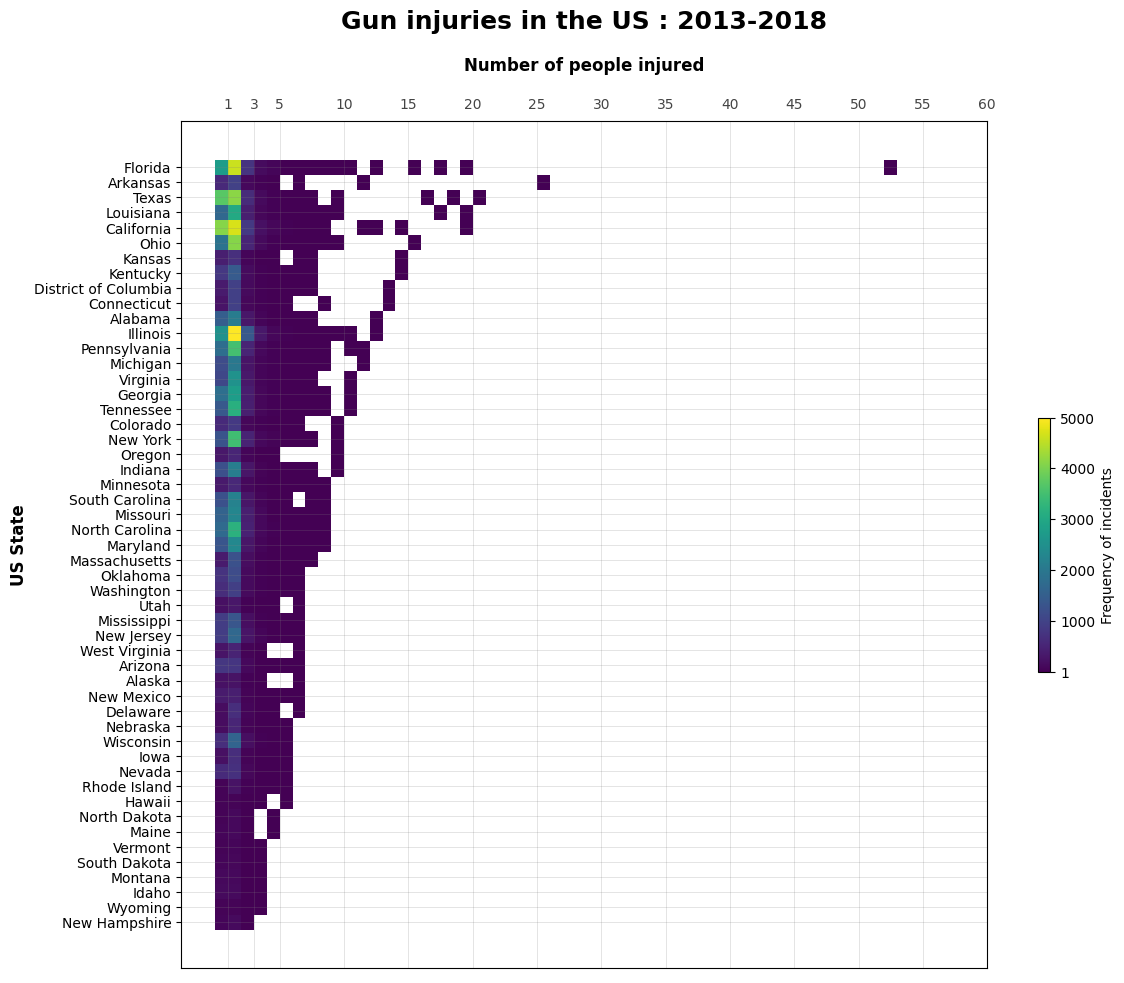

In [16]:
injured_sorted = gun_df.sort_values(by='n_injured', ascending=False)

plt.figure(figsize=(13,11))

sns.histplot(injured_sorted, 
             y="state", 
             x="n_injured", 
             alpha=1, 
             cmap='viridis', 
             legend=True, 
             binwidth=1, 
             cbar=True,
             vmax=5000,
             cbar_kws={'shrink': 0.3,'label':'Frequency of incidents', 'ticks': [1,1000,2000,3000,4000,5000]})

plt.tick_params(axis='x', top=True, labeltop=True, labelbottom=False, color='white', width=0.5, labelcolor='#444444')
plt.title('Gun injuries in the US : 2013-2018', pad=20, size=18, fontweight='heavy')
plt.xlabel('Number of people injured', labelpad=-660, size=12, fontweight='heavy')
plt.ylabel('US State', size=12, fontweight='heavy')
plt.grid('major', color='grey', linewidth='0.5', alpha=0.3, drawstyle='default')
plt.xticks([1,3,5,10,15,20,25,30,35,40,45,50,55,60])

plt.show();

***

#  Floridian gun violence <h1><img align="right" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Flag_of_Florida.svg/1280px-Flag_of_Florida.svg.png" alt="US Flag" width="250"> </h1>
<h2> Jan 2013 to Mar 2018 </h2>

## Aggregating the data

In [17]:
flo_mask = gun_df['state'] == 'Florida'       # Selecting places in Florida
flo = gun_df[flo_mask]                       

# Creating separate data frames for killed and injured
flo_killed = flo[['n_killed', 'city_or_county']]
flo_injured = flo[['n_injured', 'city_or_county']]

# Counting volume of killed and injured
flo_killed = flo_killed.groupby(["city_or_county"])['n_killed'].sum().reset_index().sort_values('n_killed', ascending=False)
flo_injured = flo_injured.groupby(["city_or_county"])['n_injured'].sum().reset_index().sort_values('n_injured', ascending=False)

# Joining data sets above into a single dataframe
flo_merged = pd.merge(flo_injured, flo_killed) 
flo_merged['total'] = flo_merged['n_injured'] + flo_merged['n_killed']              # Creating a sum of both columns
flo_final = flo_merged.sort_values(by='total', ascending=False)                     # Sorting dataframe by total 
flo_final.rename(columns={'n_injured':'injured','n_killed':'killed'}, inplace=True) # Renaming columns

## Visualising the top 20 cities or counties in Florida with most incidents


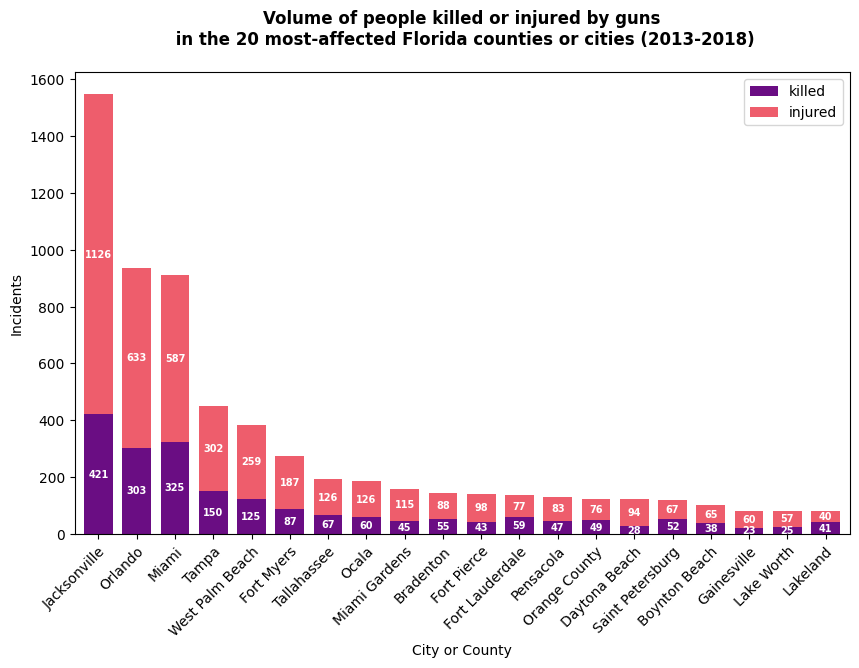

In [18]:
# Set the figure size using figsize parameter
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width and height as needed

# Your existing code for plotting and annotations
bar_anno = flo_final[0:20].plot(x='city_or_county', 
                      y=['killed', 'injured'], 
                      kind='bar', 
                      stacked=True,
                      color=['#6a0d83', '#ee5d6c'],
                      width=0.75,
                      ax=ax)  # Specify the axis for the plot

for p in bar_anno.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar_anno.text(x + width/2, 
                  y + height/2, 
                  '{:.0f}'.format(height), 
                  horizontalalignment='center',
                  size=7,
                  color='white',
                  weight='heavy',
                  verticalalignment='center')

# Your existing code for titles and labels
plt.title('Volume of people killed or injured by guns\n in the 20 most-affected Florida counties or cities (2013-2018)', pad=20, size=12, fontweight='heavy')
plt.xlabel('City or County')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Incidents')

plt.show()


***

# Californian gun violence <h1><img align="right" src="https://upload.wikimedia.org/wikipedia/commons/0/01/Flag_of_California.svg" alt="US Flag" width="250"> </h1>
<h2> Jan 2013 to Mar 2018 </h2>


## Aggregating the data

In [19]:
cali_mask = gun_df['state'] == 'California'     # Create a mask where the state is California
cali = gun_df[cali_mask]                        # Apply the mask to variable 'cali'

# Creating separate data frames for killed and injured
cali_killed = cali[['n_killed', 'city_or_county']]
cali_injured = cali[['n_injured', 'city_or_county']]

# Counting volume of killed and injured
cali_killed = cali_killed.groupby(["city_or_county"])['n_killed'].sum().reset_index().sort_values('n_killed', ascending=False)
cali_injured = cali_injured.groupby(["city_or_county"])['n_injured'].sum().reset_index().sort_values('n_injured', ascending=False)

# Joining data sets above into a single dataframe
cali_merged = pd.merge(cali_injured, cali_killed) 
cali_merged['total'] = cali_merged['n_injured'] + cali_merged['n_killed']            # Creating a sum of both columns
cali_final = cali_merged.sort_values(by='total', ascending=False)                    # Sorting dataframe by total 
cali_final.rename(columns={'n_injured':'injured','n_killed':'killed'}, inplace=True) # Renaming columns



## Visualising the top 20 cities or counties in California with most incidents


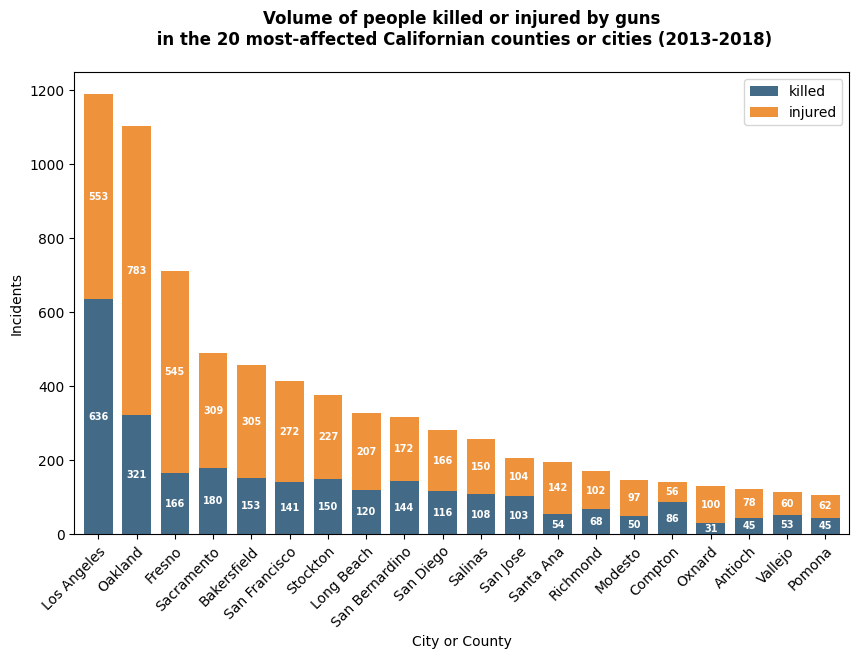

In [20]:
# Set the figure size using figsize parameter
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width and height as needed

# Your existing code for plotting and annotations
bar_anno = cali_final[0:20].plot(x='city_or_county', 
                      y=['killed', 'injured'], 
                      kind='bar', 
                      stacked=True,
                      color=['#436b88', '#ee923c'],
                      width=0.75,
                      ax=ax)  # Specify the axis for the plot

for p in bar_anno.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar_anno.text(x + width/2, 
                  y + height/2, 
                  '{:.0f}'.format(height), 
                  horizontalalignment='center',
                  size=7,
                  color='white',
                  weight='heavy',
                  verticalalignment='center')

# Your existing code for titles and labels
plt.title('Volume of people killed or injured by guns\n in the 20 most-affected Californian counties or cities (2013-2018)', pad=20, size=12, fontweight='heavy')
plt.xlabel('City or County')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Incidents')

plt.show()


***

# Finding the most-used type of weapon

Aggregating & cleaning the data:

In [21]:
df = gun_violence_cleaned.copy()
split_df = df['gun_type'].str.split('|', expand=True)        # Split gun_types column into multiple columns
split_df.fillna(value=np.nan)
split_df.replace(r'^\s*$', np.nan, regex=True, inplace=True) # Replace empty values with NaN
stacked_df = pd.DataFrame(split_df.stack(dropna=True)).reset_index().drop(columns='level_1') # Stack the DataFrame, reset index, drop column
stacked_df.rename(columns={0:'weapon'}, inplace=True) # Renaming the column
stacked_df['weapon'] = stacked_df['weapon'].str.lstrip('0123456789:: ')  # Removing unnecessary info
final_weapon_count = stacked_df['weapon'].value_counts().reset_index()

## Creating a horizontal bar plot:

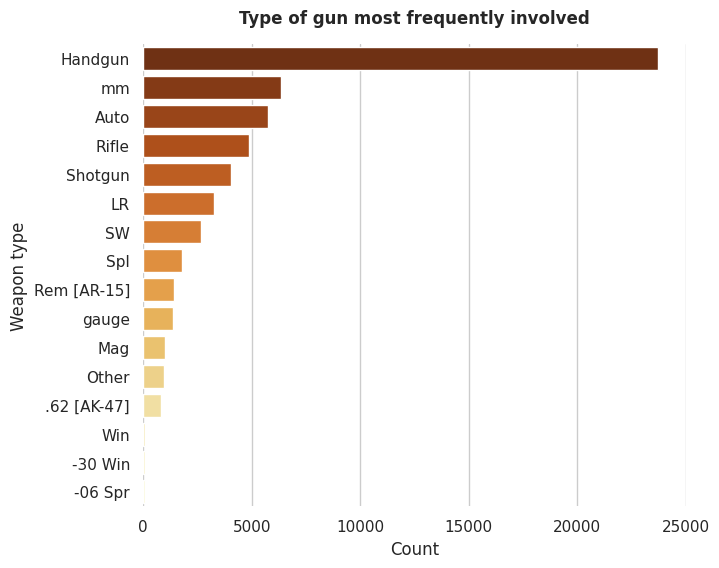

In [22]:
sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(7,6))

sns.barplot(y='weapon', x='count', data=final_weapon_count, palette='YlOrBr_r')

plt.title('Type of gun most frequently involved',pad=15, size=12, fontweight='heavy')
plt.xticks(ticks=[0,5000,10000,15000,20000,25000], rotation=0, horizontalalignment='center')
plt.xlabel('Count')
plt.ylabel('Weapon type')

sns.despine(left=True, bottom=True)
plt.show(fig);